# Capstone Project I - Diabetes Feature Engineering

**Author: Eda AYDIN**

This project was done in Miuul Machine Learning Summer Camp.

## 1. Business Problem
It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

## 2. Dataset Story
The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

| Pregnancies              | Hamilelik Sayısıs                                                      |
|--------------------------|------------------------------------------------------------------------|
| Glucose                  | Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu   |
| BloodPressure            | Kan Basıncı (Küçük tansiyon) (mm Hg)                                   |
| SkinThickness            | Cilt Kalınlığı                                                         |
| Insulin                  | 2 saatlik serum insulini (mu U/ml)                                     |
| DiabetesPedigreeFunction | Soydaki kişilere göre diyabet olma ihtimalini hesaplayan bir fonksiyon |
| BMI                      | Vücut kitle endeksi                                                    |
| Age                      | Yaş (yıl)                                                              |
| Outcome                  | Hastalığa sahip (1) ya da değil (0)                                    |

## 3. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 3.1 Examine the overall picture.

In [2]:
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
def check_dataframe(dataframe, head=5):
    print("##### Shape #####")
    print(dataframe.shape)

    print("\n##### Types #####")
    print(dataframe.dtypes)

    print("\n##### Tail #####")
    print(dataframe.tail(head))

    print("\n##### Head #####")
    print(dataframe.head(head))

    print("\n##### Null Analysis #####")
    print(dataframe.isnull().sum())

    print("\n##### Quantiles #####")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_dataframe(df)

##### Shape #####
(768, 9)

##### Types #####
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

##### Tail #####
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.900                     0.171   63        0
764            2      122             70             27        0 36.800                     0.340   27        0
765            5      121             72             23      112 26.200                     0.245   30        0
766            1      126             60              0        0 30.100                     0.349   47        1
767            1       93             

Veri Kısa Analizi: 
- Tip değişkeninde ilk bakıldığında tüm değerler sayısal değişken olarak görünüyor. Gerçekten böyle mi bakılması gerekiyor.
- Veride Glikoz, Kan Basıncı, Cilt kalınlığı, İnsulin, Beden Kitle İndeksi gibi değerlerin minimim değerinin sıfır olduğu görünüyor Bunun mümkün olmadığının bilimsel olarak farkında olduğumuzdan dolayı, bu verilere ayrıyeten bakılması gerekiyor. Ayrıca bu veri seti teslim edilmeden önce NaN değerlerin 0 ile doldurulmuş ihtimali de aklımıza geliyor.
    - 0 olan değerle NaN ifadesi ile değiştirileceği zaman Pregnancies gibi 0 olma ihtimali olan sütunlar dışarıda tutulmalıdır. 
- Verinin içerisinde NaN değerler de bulunmuyor. Bunun da ayrıyeten incelenmesi gerekiyor.
- Quantile değerler içerisinde 0.99 ile 1 arasında büyük bir sıçrama varsa, aslında burada aykırı değer olduğu anlamına gelmektedir.
    - Örnek: İnsülin sütunu (519 --> 846)
- Hamilelik sütununun maximum değerinin 17 olduğunu görüyorum. Bunun gerçek olma ihtimalini literatür taraması yaparak araştırmam gerekiyor. Veri bilimci gözüyle herhangi bir şey diyemem. 

-----

Data Short Analysis:
- All values appear to be a numerical variable in the first type of type variable.Is it really like that.
- The minimal value of the values such as glucose, blood pressure, skin thickness, insulin, body mass index appears to be zero.Since we are scientifically aware that this is not possible, these data should be looked at. In addition, before this data set is delivered, we can think of the possibility of nan values filled with 0.
    - When it is replaced with the expression of 0 with the value of 0, columns that are likely to be 0 such as pregnancies should be kept outside.
- There are no nan values in the data.This also needs to be examined.
- If there is a large leap between 0.99 and 1 in the quantile values, it means that there is actually a contradictory value here.
    -Example: insulin column (519 -> 846)
- I see that the maximum value of pregnancy column is 17 maximum value.I need to investigate the possibility of this being real by scanning literature.I can't say anything with the data scientist. 

### 3.2 Capture the numeric and categorical variables.

In [5]:
def grab_col_names(dataframe, categorical_threshold=10, cardinal_threshold=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal,nominal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if
                    dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if
                     dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [6]:
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df)

Observations: 768
Variables: 9
categorical_cols: 1
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 1


In [7]:
print("Categorical column names: {}".format(categorical_cols))
print("Numerical column names: {}".format(numerical_cols))
print("Cardinal column names: {}".format(cardinal_cols))
print("Nominal column names: {}".format(nominal_cols))

Categorical column names: ['Outcome']
Numerical column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Cardinal column names: []
Nominal column names: ['Outcome']


### 3.3 Analyze the numerical and categorical variables.

#### Analysis of Categorical Columns

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("{} Count Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Count Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


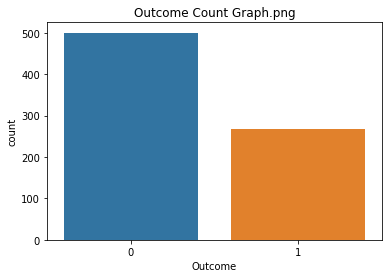

In [9]:
cat_summary(df, "Outcome", True)

Analysis: 
- We observe that there are 1/3 diabetes patients, not 2/3 diabetes.
- 0: Not with diabetes, 1 diabetic patient

#### Analysis of Numerical Columns

In [10]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        dataframe[col_name].hist()
        plt.xlabel(col_name)
        plt.title("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

Pregnancies
count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


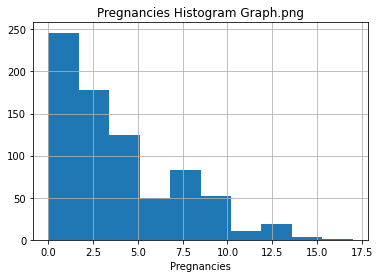

Glucose
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


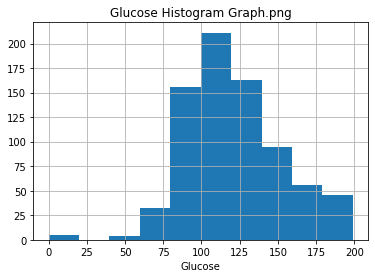

BloodPressure
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


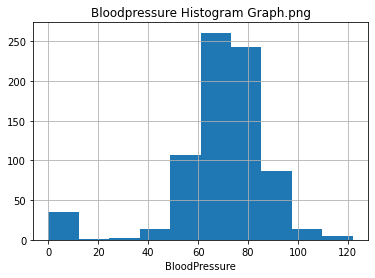

SkinThickness
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


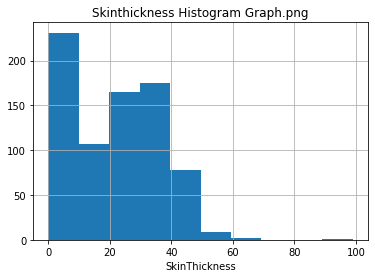

Insulin
count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


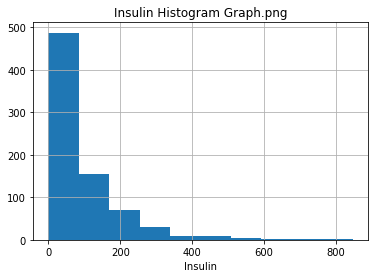

BMI
count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


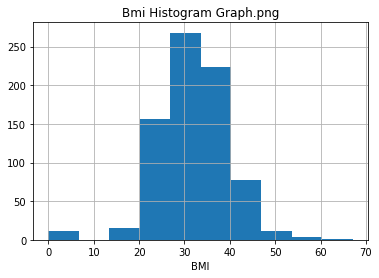

DiabetesPedigreeFunction
count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


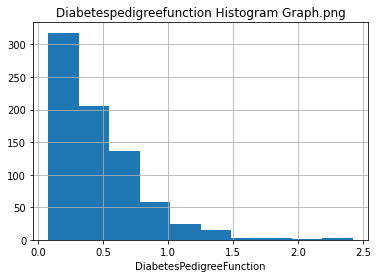

Age
count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


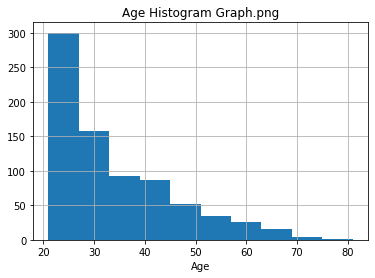

In [11]:
for col in numerical_cols:
    print(col)
    num_summary(df, col, True)

Analysis:
- Genellikle standart sapmanın ortalamadan daha küçük olması beklenir. Ortalamanın standard sapmadan fazla olması o veride dengesizlik var demektir. Standard sapmanın fazla olması dağılım çok fazla olmasından kaynaklanır. 
- Hamilelik sütunu maksimum 17 kez hamile kalınabilirliği literatür taramasında geçmek zorundadır.
- Glikoz sütunu için minimum değeri 0 olamaz. Mean ile quartile %50 (medyanın) birbirine yakın değerler içeriyor. O zaman normal bir dağılım var diyebiliriz. %99 quartile ile maximum değerler birbirine yakın. Yani büyük bir sıçrama yok, ki bu da aykırı bir değer olmadığı anlamına geliyor.
- Kan basıncının minimum değeri 0 olamaz. 
- SkinThickness sütunu için 99% ile maximum değer arasında bir uçurum var görünüyor, bu da bir aykırı değerlerin olduğu anlamına geliyor.
- İnsülin değer standard sapma mean değerinden yüksek gelmiş. %99 ile maximum değer arasında bir uçurum var. Ki bu da bu sütun için aykırı değerin çok olduğu anlamına gelmektedir.
- BMI sütununda minimum değeri 0 olamaz. Standard sapma mean değerinden düşük, veri de herhangi bir sıçrama yok. Bu da 99% ile maximum değer arasında ufakta olsa bir sıçrama var. Aykırı değer olup olmadığına bakılacak.
- Age ve DiabetesPedigreeFunction sütunlarında göze çarpan herhangi bir şey gözlenmedi.

------

Analysis:
- Ussuallly standard deviation is expected to be smaller Than The Mean.The fact that the average is more than the standard deviation means imbalance in that data.The high standard deviation is due to the fact that the distribution is too high.
- The pregnancy column has to be included in the literature review for a maximum of 17 fecundity times.
- - The minimum value for the glucose column cannot be 0. Mean and quartile 50% (of the media) contain values ​​close to each other. Then we can say that there is a normal distribution. 99% quartile and maximum values ​​are close to each other. So no big jump, which means no outliers.
- The minimum value of blood pressure cannot be 0.
- There seems to be a gap between 99% and the maximum value for the SkinThickness column, which means there are outliers.
- Insulin value is higher than standard deviation mean value. There is a gap between 99% and the maximum value. Which means that there are many outliers for this column.
- The minimum value in the BMI column cannot be 0. The standard deviation is less than the mean value, and there is no jump in the data. There is a slight jump between 99% and the maximum value. It will be checked for outliers.
- Nothing conspicuous was observed in the Age and DiabetesPedigreeFunction columns.

### 3.4 Perform target variable analysis according to numerical variables.

(The mean of the target variable according to the categorical variables, the mean of the numerical variables according to the target variable) 

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in numerical_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




Analysis:
- For the pregnancy variant
    - average pregnancy rate of non-diabetics: 3,298
    - average pregnancy for those with diabetes: 4,866
- For the glucose variable: **(high value - requires detailed examination)**
    - glucose average of non-diabetics: 109,980
    - glucose average of those with diabetes: 141.257
- For the blood pressure (Small Blood Pressure) variant:
    - mean diastolic blood pressure of non-diabetics: 68,184
    - average diastolic blood pressure of those with diabetes: 70,825
- For the skin thickness variant:
    - mean skin thickness of non-diabetics: 19,664
    - average skin thickness of those with diabetes: 22,164
- For insulin variable: **(high value - requires detailed examination)**
    - mean insulin of non-diabetics: 68,792
    - insulin average of diabetics: 100,336
- For the BMI variable:
    - average BMI of non-diabetics: 30,384
    - average BMI of those with diabetes: 35,143
- For a function variable that calculates the probability of having diabetes in descendants:
    - non-diabetes average for DiabetesPedigreeFunction: 0.430
    - diabetes average for DiabetesPedigreeFunction: 0.550
- For the age variable: **(high value - requires detailed examination)**
    - average age of non-diabetics: 31,190
    - average age of those with diabetes: 37,067

-------

Analiz:
- Hamilelik değişkeni için 
    - diyabet olmayanların hamile kalma ortalaması : 3.298
    - diyabet olanların hamile kalma ortalaması: 4.866
- Glikoz değişkeni için: **(değer yüksek - ayrıntılı incelenmesi gerekir)**
    - diyabet olmayanların glikoz ortalaması: 109.980
    - diyabet olanların glikoz ortalaması: 141.257 
- Kan basıncı (Küçük Tansiyon) değişkeni için:
    - diyabet olmayanların küçük tansiyon ortalaması: 68.184
    - diyabet olanların küçük tansiyon ortalaması: 70.825
- Cilt kalınlığı değişkeni için:
    - diyabet olmayanların cilt kalınlığı ortalaması: 19.664
    - diyabet olanların cilt kalınlığı ortalaması: 22.164
- İnsülin değişkeni için: **(değer yüksek - ayrıntılı incelenmesi gerekir)**
    - diyabet olmayanların insulin ortalaması: 68.792
    - diybaet olanların insülin ortalaması: 100.336
- Vücut kitle indeksi değişkeni için:
    - diyabet olmayanların BMI ortalaması: 30.384
    - diyabet olanların BMI ortalaması: 35.143
- Soydaki kişilere gire diyabet olma ihtimalini hesaplayan bir fonksiyon değişkeni için:
    - diyabet olmayanların  DiabetesPedigreeFunction için ortalaması: 0.430
    - diyabet olanların DiabetesPedigreeFunction için ortalaması: 0.550
- Yaş değişkeni için:  **(değer yüksek - ayrıntılı incelenmesi gerekir)**
    - diyabet olmayanların yaş ortalaması: 31.190
    - diyabet olanların yaş ortalaması: 37.067


### 3.5 Perform correlation analysis

**What does the correlation matrix tell us?**

- The correlation matrix shows the relationship between two values. It shows how connected they are with each other. The higher the commitment, the more compatible the two variables are. If the correlation value is too high, both values must be kept in the dataframe. Because that can cause bias.

**What does it mean to us that the correlation value is - and +?**

- Values close to -1 are interpreted as **negative correlation**, values close to +1 are interpreted as **positive correlation**.
- The values of two variables with **positive correlation** increase or decrease together.
- As the value of one of the two variables with **negative correlation** increases, that of the other decreases.

- If the value is close to 0, it indicates that there is no connection between these two variables.

------

**Korelasyon matrix'i bize ne anlatır?**

- Korelasyon matrix'i iki değerin birbiri ile ilişki gösterir. Birbirleri ile ne kadar bağlı olduğunu gösterir. Bağlılık ne kadar yüksekse, iki değişkenin birbirleri uyumlu olduğunu gösterir. Korelasyon değeri çok yüksekse, iki değeri de dataframe içerisinde tutulması gerekir. Çünkü bu bias'a neden olabilir.

**Korelasyon değerinin - ve + olması bize ne anlam ifade eder?**

- -1'e yakın değerler **negatif korelasyon**, +1'e yakın değerler **pozitif korelasyon** olarak yorumlanır. 

- **Pozitif korelasyon**a sahip iki değişkenin değerleri birlikte artar veya azalır.
- **Negatif korelasyon**a sahip iki değişkenlerden birinin değeri artarken diğerininki azalır. 

- Değerin 0'a yakın olması durumu ise bu iki değişken arasında bir bağlantı olmadığını gösterir.

In [13]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


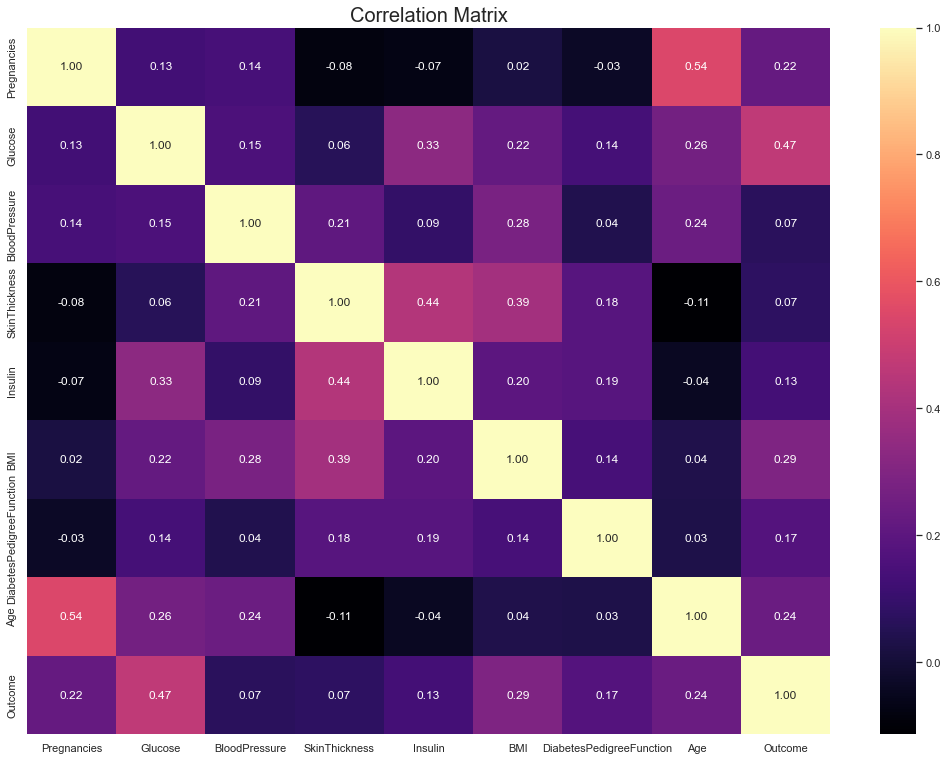

<Figure size 432x288 with 0 Axes>

In [26]:

# Correlation matrix

f,ax = plt.subplots(figsize=[18,13])
sns.heatmap(df.corr(), annot=True, fmt=".2f",ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

plt.savefig("Correlation Matrix.png")

Analysis:
- We can see that the variables of Age and Pregnancy have a high correlation with each other. (Correlation value: 0.54)
- We can see that the probability of glucose and diabetes has a high correlation with each other. (Correlation value: 0.47)
- The probability of diabetes is most affected by Glucose, BMI, Age and Pregnancy.

-------

Analiz:
- Yaş ve Hamilelik değişkenlerinin birbiri ile yüksek korelasyona sahip olduğunu görebiliriz. (Korelasyon değeri: 0.54)
- Glikoz ve diyabet olma olasılığı birbiri ile yüksek korelasyona sahip olduğunu görebiliriz. (Korelasyon değeri: 0.47)
- Diyabet olma olasılığı en çok Glikoz, BMI, Yaş ve Hamilelik etkiliyor.




###  3.6 Base Model Setup

In [15]:
y = df["Outcome"]
X = df.drop("Outcome",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=17)

In [16]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


- Accuracy: We won't be looking at the accuracy result here. Accuracy value is thought to cause bias in classification problems.
- Recall: Shows how many people who actually have diabetes are called diabetes.
- Precision: Shows how many of the diabetes predicted by the model are diabetes.
- F1: Harmonic average of Recall and Precision values.
- Auc: It gives us success result according to different classification threshold values.

-----

- Accuracy:Burada accuracy sonucuna bakamayacağız. Classification problemlerinde Accuracy değerinin yanlılığa sebep olduğu düşünülüyor.
- Recall: Gerçekte diyabet olanların kaçının diyabet dendiğini gösteriyor.
- Precision: Model tarafından tahmin edilen diyabetlerin kaçının diyabet olduğunu gösteriyor.
- F1: Recall ile Precision değerlerinin harmonik ortalaması. 
- Auc:Farklı sınıflandırma eşik değerlerine göre bize başarı sonucunu veriyor.

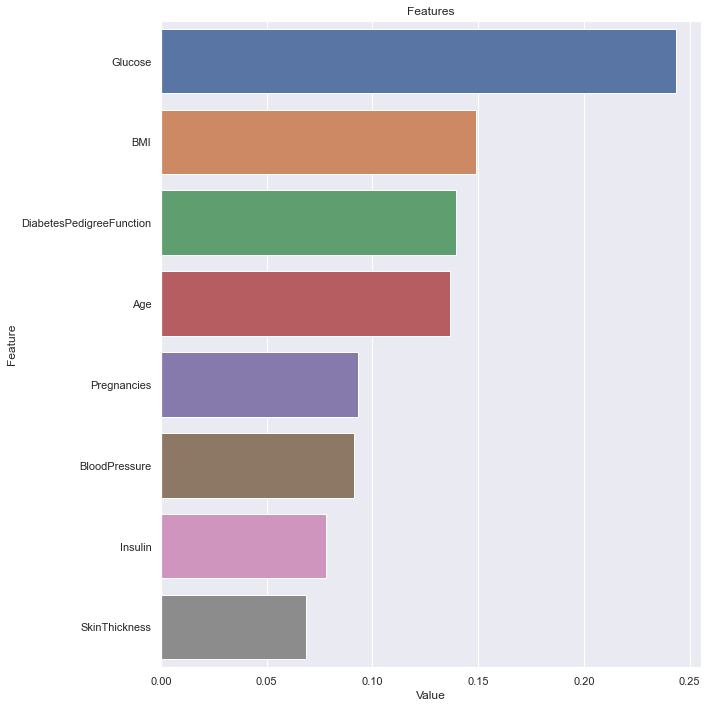

<Figure size 432x288 with 0 Axes>

In [25]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
plot_importance(model=rf_model, features=X, save=True)

## 4. Feature Engineering

### 4.1 Perform missing observation analysis.

- Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
- Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .

----- 

- It is known that a human cannot have variable values 0 other than Pregnancies and Outcome.
- Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.

In [28]:
zero_columns = [col for col in df.columns if (df[col].min() == 0  and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Looking at each of the variables of 0 in the observation units, we replaced the observation values containing 0 with nan.

------

Gözlem birimlerinde 0 olan değişkenlerin her birisine bakarak 0 içeren gözlem değerlerini NaN ile değiştirdik.


In [29]:
for col in zero_columns:
    df[col] = np.where(df[col]==0, np.nan, df[col])


#### 4.1.1 Analysis of Missing Values

In [31]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [32]:
def missing_values_table(dataframe, na_name=False):
    
    # Column Names with Missing Values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    # Number of Missing Values of One Column
    number_of_missing_values = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    
    # Percentage Distribution of Missing Data
    percentage_ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    # Dataframe with Missing Data
    missing_df = pd.concat([number_of_missing_values, np.round(percentage_ratio, 2)], axis=1, keys=['number_of_missing_values', 'percentage_ratio'])
    
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [33]:
na_columns = missing_values_table(df, na_name=True)

               number_of_missing_values  percentage_ratio
Insulin                             374            48.700
SkinThickness                       227            29.560
BloodPressure                        35             4.560
BMI                                  11             1.430
Glucose                               5             0.650


#### 4.1.2 Investigation of the relationship of missing values with the dependent variable

In [34]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [35]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




Analysis:
- We can say that the fact that there is a nan expression in the Insulin variable does not affect whether a person has diabetes.

-----

Analiz: 
- Insülin değişkeninde nan ifade olup olmaması bir kişinin diyabet olup olmamasını bu verinin içerisinde etkilemediğini söyleyebiliriz.

#### 4.1.3 Filling the missing values

In [36]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

In [37]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### 4.2 Perform outlier observation analysis.

In [38]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + (1.5 * interquartile_range)
    low_limit = quartile1 - (1.5 * interquartile_range)
    return low_limit, up_limit

In [39]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [40]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

#### 4.2.1 Outlier Analysis and Suppression Process

In [41]:
for col in df.columns:
    print(col, check_outlier(df,col))
    if check_outlier(df, col):
        replace_with_thresholds(df,col)

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [42]:
for col in df.columns:
    print(col,check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


### 4.3 Feature Extraction

#### 4.3.1 Divide the age variable into categories and create a new age variable

In [43]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"


#### 4.3.2 BMI 18.5 below Underweight, 18.5 to 24.9 normal, 24.9 to 29.9 overweight and over 30 obese

In [44]:

# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])


#### 4.3.3 Converting glucose value to categorical variables

In [45]:

# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])


#### 4.3.4 Creating categorical variables by thinking about age and body mass index together

In [46]:

# # Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"


#### 4.3.5 Creating categorical variables by considering age and glucose values together

In [47]:

# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (
        (df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


#### 4.3.6 Derive categorical variables with insulin value

In [48]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [49]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

In [50]:

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]


#### 4.3.7 Fascination of columns

In [52]:
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10045.875,89.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,mature,Obese,Normal,obesemature,highmature,Normal,18614.875,0.000


In [53]:
df.shape

(768, 17)

### 4.4 Encoding

In [54]:
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df)

Observations: 768
Variables: 17
categorical_cols: 7
numerical_cols: 10
cardinal_cols: 0
nominal_cols: 3


#### 4.4.1 Label Encoding

In [55]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [56]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [57]:
for col in binary_cols:
    df = label_encoder(df, col)

In [58]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,Overweight,Normal,obesemature,normalmature,Normal,10045.875,89.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,Obese,Normal,obesemature,highmature,Normal,18614.875,0.000


#### 4.4.2 One-Hot Encoding

In [59]:
# Updating the categorical_cols
categorical_cols = [col for col in categorical_cols if col not in binary_cols and col not in ["OUTCOME"]]
categorical_cols

['NEW_AGE_BMI_NOM',
 'NEW_AGE_GLUCOSE_NOM',
 'NEW_INSULIN_SCORE',
 'NEW_BMI',
 'NEW_GLUCOSE']

In [60]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [61]:
df = one_hot_encoder(df, categorical_cols, drop_first=True)

In [62]:
df.shape

(768, 26)

In [63]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,18500.000,888.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,10625.000,85.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,22875.000,1464.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,10045.875,89.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,18614.875,0.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### 4.5 Scaling

- **StandardScaler**: Ortalaması 0, Standard Sapması 1 olacak şekilde değiştirilir.
- **MinMaxScaler**: Verilen min ve max değerleri arasında standartlaştırma yapar.
- **RobustScaler**: Aykırı değere dayanıklı bir şekilde, çeyreklik değerlerine göre medyan değerini için içerisinde tutarak bır standartlaştırma yapar. 

In [64]:
numerical_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [65]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

**fit** ile veri yapısı öğrenilir. **transform** ile öğrenilen bilgiyi standartlaştırdığı değerlere dönüştürür.

In [66]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,1,0.750,0.893,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,0,-1.078,-0.864,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,0,1.766,2.154,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0,-1.212,-0.855,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,0,0.777,-1.050,0,0,0,1,0,0,0,0,0,0,0,1,0,0


## Modelling

In [67]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


In [68]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


In [69]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.8
Recall: 0.73
Precision: 0.67
F1: 0.7
Auc: 0.78


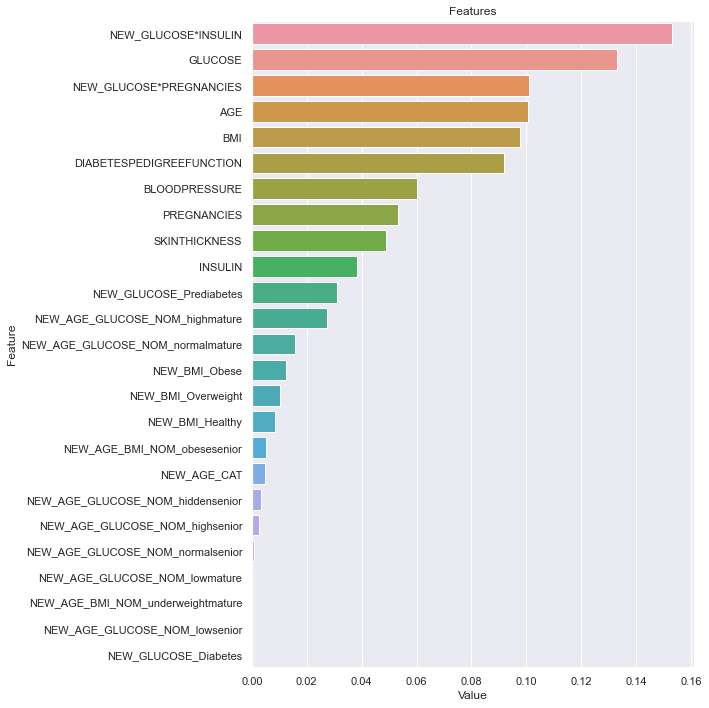

<Figure size 432x288 with 0 Axes>

In [71]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances_after_modelling.png')


plot_importance(rf_model, X,save = True)